In [1]:
# ! pip install PyMaxflow
# ! pip install mediapy

In [2]:
import numpy as np
import cv2
import maxflow
import mediapy as mpy
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt


## Question 3: Denosing binary image using Markov Random Field (MRF)
Unaries are defined by
$$
\begin{align*}
P(x_n | w_{n} = 0 ) &&  =  && Bern_{x_n} [\rho]      && = && \rho^{x_{n}} (1-\rho)^{1-x_{n}} \\
P(x_n | w_{n} = 1 ) &&  =  && Bern_{x_n} [1 - \rho]  && = && (1-\rho)^{x_{n}} \rho^{1-x_{n}}\\
U_{n}(w_{n})        &&  =  && -log(P(x_{n}|w_{n})) \\
\end{align*}
$$

where $\rho=0.7$. Here $1-\rho$ is probablilty of flipping the polarity. 


We will label pixels where the edge to the source was cut as $w_{n} = 0$ 
and pixels where the edge to the sink was cut as having label $w_{n} = 1$. 

In [3]:
def plot_result(img, denoised_img, rho, pairwise_same, pairwise_diff, figsize=(15, 7)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    fig.suptitle(f"Result for rho={rho} pairwise_cost_same={pairwise_same} and pairwise_cost_diff={pairwise_diff} ", fontsize=16)
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Noisy Image")
    axes[0].tick_params(labelbottom=False, labelleft=False)
    
    axes[1].imshow(denoised_img, cmap='gray')
    axes[1].set_title("Denoised Image")
    axes[1].tick_params(labelbottom=False, labelleft=False)
    

In [4]:
def compute_unary_cost(img, w_n, rho, cost_same):
    unary_potential = np.where(img == w_n, 1-rho, rho)
    unary_potential = -np.log(unary_potential) + cost_same
    return unary_potential


def compute_pairwise_cost(img, pairwise_cost_same=0.01, pairwise_cost_diff=0.8, axis=1):
    "or use structure for weights"
    weight = np.zeros_like(img)
    num_rows = img.shape[0]
    num_cols = img.shape[1]
    
    if axis == 0:
       # ignore last row to avoid out of bound index
        num_rows -= 1
    else:
        # ignore last column to avoid out of bound index 
        num_cols -= 1
        
    for i in range(num_rows):
        for j in range(num_cols):
            # checking vertical connections
            if axis == 0:
                if img[i, j] == 0.0 and img[i+1, j] == 0.0:
                    weight[i, j] = pairwise_cost_same
                elif img[i, j] == 1.0 and img[i+1, j] == 1.0:
                    weight[i, j] = pairwise_cost_same
                else:
                    weight[i, j] = pairwise_cost_diff
            
            # checking horizontal connections
            else:
                if img[i, j] == 0.0 and img[i, j+1] == 0.0:
                    weight[i, j] = pairwise_cost_same
                elif img[i, j] == 1.0 and img[i, j+1] == 1.0:
                    weight[i, j] = pairwise_cost_same
                else:
                    weight[i, j] = pairwise_cost_diff
    return weight


In [5]:
def denoise_binary_image(I, rho, c_same, c_diff):
    result_dict = {}
    
    I = I.astype('float')/255.0
    ### Create Graph
    g = maxflow.Graph[float]()

    ### Add pixels as nodes
    nodeids = g.add_grid_nodes(I.shape)

    ### Compute Unaray cost
    U_0 = compute_unary_cost(I, w_n=0, rho=rho, cost_same=c_same)
    U_1 = compute_unary_cost(I, w_n=1, rho=rho, cost_same=c_same)

    ### Add terminal edges
    g.add_grid_tedges(nodeids, U_0, U_1)

    ### Add Node edges
    ### Vertical Edges
    p_ba = c_diff
    p_ab = c_diff - 2*c_same
    structure = np.array([[0, p_ba, 0],
                          [0, 0, 0],
                          [0, p_ab, 0]])
    g.add_grid_edges(nodeids, structure=structure, symmetric=False)

    ### Horizontal edges
    structure = np.array([[0, 0, 0],
                          [p_ba, 0, p_ab],
                          [0, 0, 0]])
    g.add_grid_edges(nodeids, structure=structure, symmetric=False)
    
    # G = g.get_nx_graph()
    # adj_matrix = nx.to_numpy_array(G, weight='weight')
    # assert (adj_matrix > 0).all(),\
    #     f"Graph is has negative edge weights rho={rho}, c_same={c_same}, c_diff={c_diff}"
    
    ### Maxflow
    g.maxflow()

    sgm    = g.get_grid_segments(nodeids)
    result_dict['segmets'] = sgm
    Denoised_I = np.int_(sgm)
    
    result_dict['Denoised_I'] = Denoised_I.astype('uint8')*255
    result_dict['graph'] = g
    result_dict['nodeids'] = nodeids
    result_dict['U_0'] = U_0
    result_dict['U_1'] = U_1
    
    return result_dict

In [6]:
image = cv2.imread('./images/noisy_binary_img.png', cv2.IMREAD_GRAYSCALE)

We consider denoising binary images in which the noise process flips the pixel polarity with
probability  $\rho$.

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 184.42it/s]


100


P_S=0.00/P_D=0.00,P_S=0.00/P_D=0.10,P_S=0.00/P_D=0.20,P_S=0.00/P_D=0.30,P_S=0.00/P_D=0.40,P_S=0.00/P_D=0.50,P_S=0.00/P_D=0.60,P_S=0.00/P_D=0.70,P_S=0.00/P_D=0.80,P_S=0.00/P_D=0.90
P_S=0.10/P_D=0.00,P_S=0.10/P_D=0.10,P_S=0.10/P_D=0.20,P_S=0.10/P_D=0.30,P_S=0.10/P_D=0.40,P_S=0.10/P_D=0.50,P_S=0.10/P_D=0.60,P_S=0.10/P_D=0.70,P_S=0.10/P_D=0.80,P_S=0.10/P_D=0.90
P_S=0.20/P_D=0.00,P_S=0.20/P_D=0.10,P_S=0.20/P_D=0.20,P_S=0.20/P_D=0.30,P_S=0.20/P_D=0.40,P_S=0.20/P_D=0.50,P_S=0.20/P_D=0.60,P_S=0.20/P_D=0.70,P_S=0.20/P_D=0.80,P_S=0.20/P_D=0.90
P_S=0.30/P_D=0.00,P_S=0.30/P_D=0.10,P_S=0.30/P_D=0.20,P_S=0.30/P_D=0.30,P_S=0.30/P_D=0.40,P_S=0.30/P_D=0.50,P_S=0.30/P_D=0.60,P_S=0.30/P_D=0.70,P_S=0.30/P_D=0.80,P_S=0.30/P_D=0.90
P_S=0.40/P_D=0.00,P_S=0.40/P_D=0.10,P_S=0.40/P_D=0.20,P_S=0.40/P_D=0.30,P_S=0.40/P_D=0.40,P_S=0.40/P_D=0.50,P_S=0.40/P_D=0.60,P_S=0.40/P_D=0.70,P_S=0.40/P_D=0.80,P_S=0.40/P_D=0.90
P_S=0.50/P_D=0.00,P_S=0.50/P_D=0.10,P_S=0.50/P_D=0.20,P_S=0.50/P_D=0.30,P_S=0.50/P_D=0.40,P_S=0.50/P_D=0.50,P_S=0.50/P_D=0.60,P_S=0.50/P_D=0.70,P_S=0.50/P_D=0.80,P_S=0.50/P_D=0.90
P_S=0.60/P_D=0.00,P_S=0.60/P_D=0.10,P_S=0.60/P_D=0.20,P_S=0.60/P_D=0.30,P_S=0.60/P_D=0.40,P_S=0.60/P_D=0.50,P_S=0.60/P_D=0.60,P_S=0.60/P_D=0.70,P_S=0.60/P_D=0.80,P_S=0.60/P_D=0.90
P_S=0.70/P_D=0.00,P_S=0.70/P_D=0.10,P_S=0.70/P_D=0.20,P_S=0.70/P_D=0.30,P_S=0.70/P_D=0.40,P_S=0.70/P_D=0.50,P_S=0.70/P_D=0.60,P_S=0.70/P_D=0.70,P_S=0.70/P_D=0.80,P_S=0.70/P_D=0.90
P_S=0.80/P_D=0.00,P_S=0.80/P_D=0.10,P_S=0.80/P_D=0.20,P_S=0.80/P_D=0.30,P_S=0.80/P_D=0.40,P_S=0.80/P_D=0.50,P_S=0.80/P_D=0.60,P_S=0.80/P_D=0.70,P_S=0.80/P_D=0.80,P_S=0.80/P_D=0.90
P_S=0.90/P_D=0.00,P_S=0.90/P_D=0.10,P_S=0.90/P_D=0.20,P_S=0.90/P_D=0.30,P_S=0.90/P_D=0.40,P_S=0.90/P_D=0.50,P_S=0.90/P_D=0.60,P_S=0.90/P_D=0.70,P_S=0.90/P_D=0.80,P_S=0.90/P_D=0.90

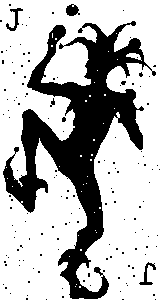
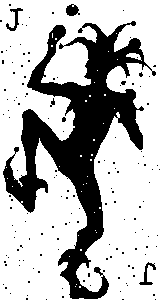
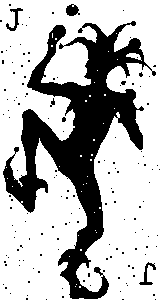
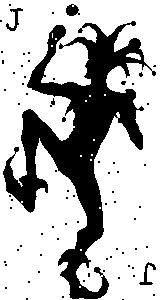
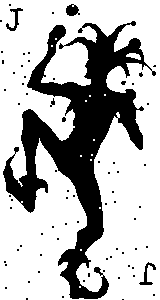
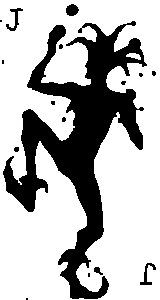
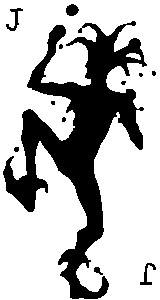
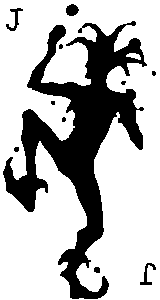
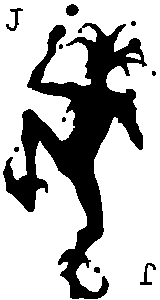
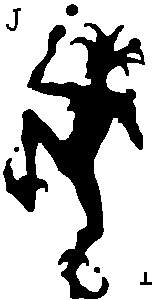
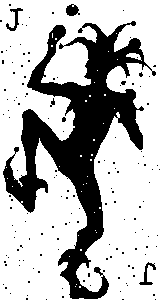
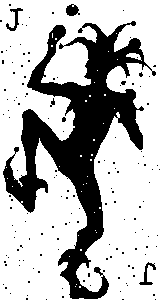
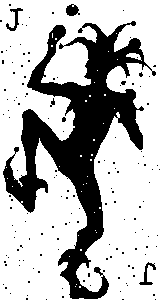
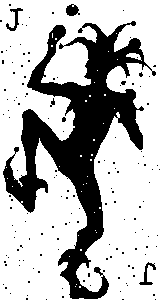
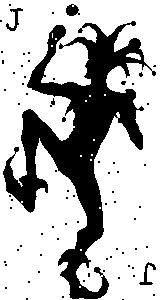
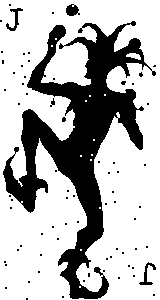
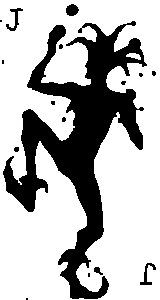
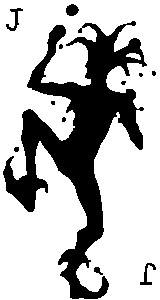
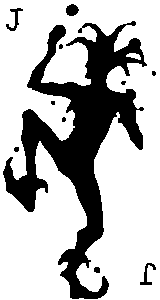
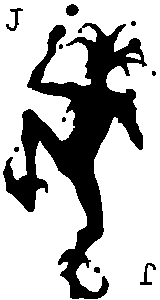
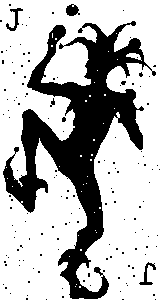
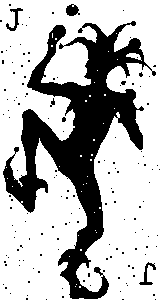
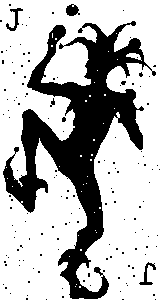
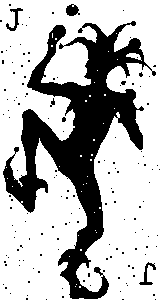
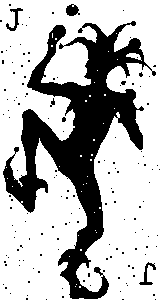
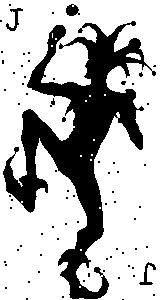
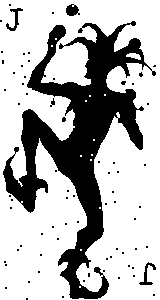
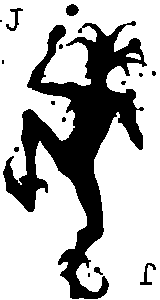
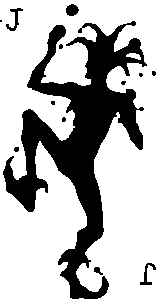
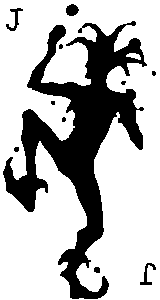
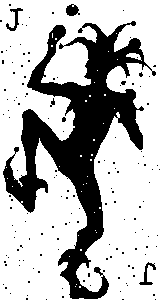
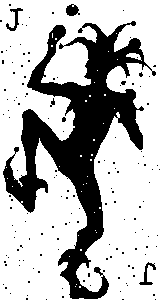
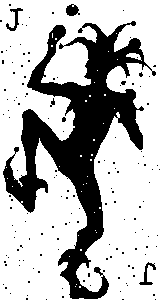
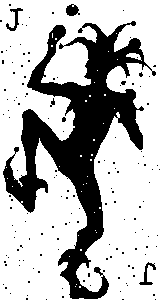
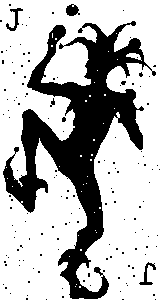
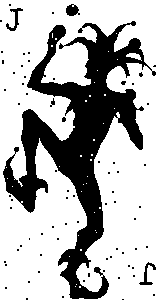
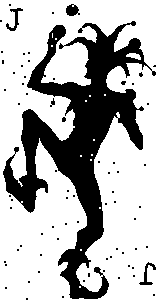
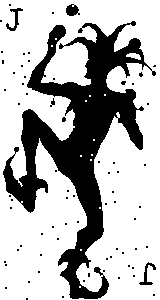
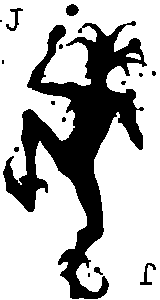
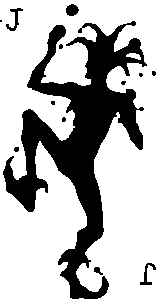
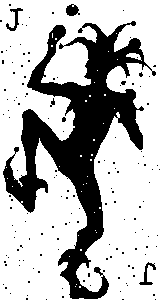
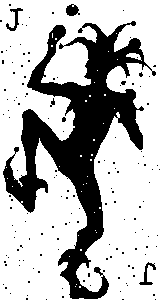
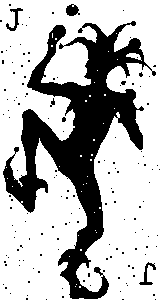
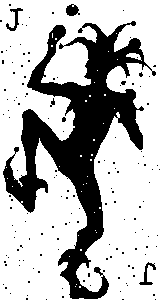
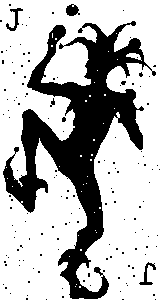
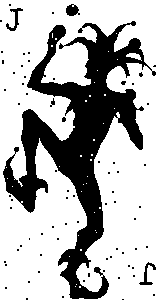
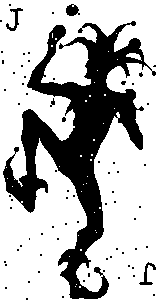
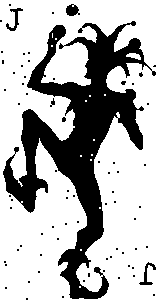
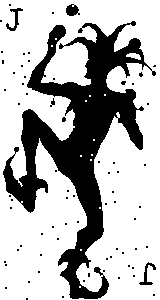
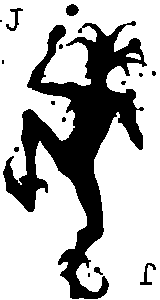
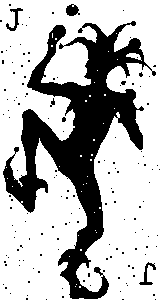
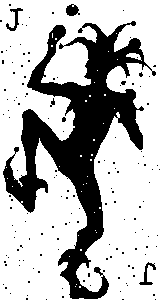
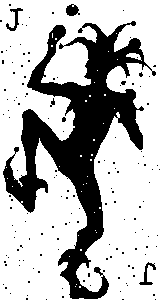
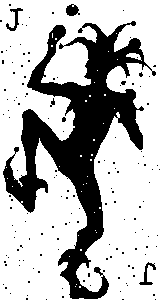
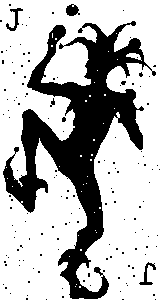
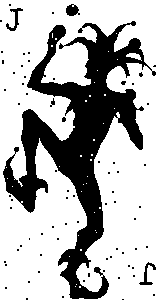
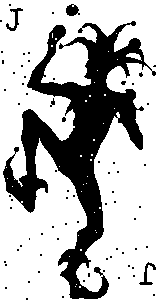
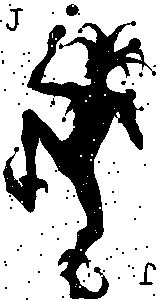
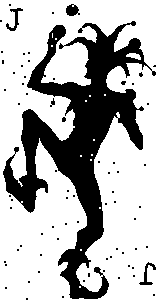
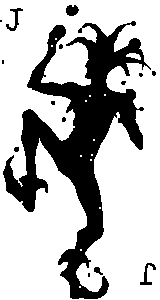
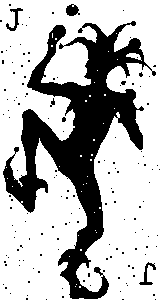
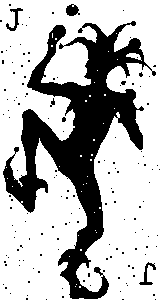
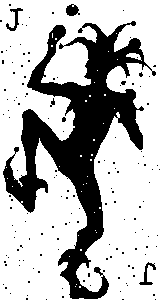
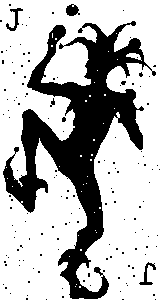
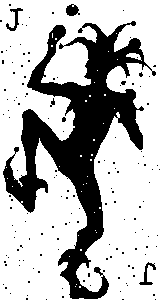
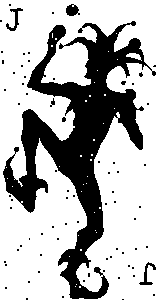
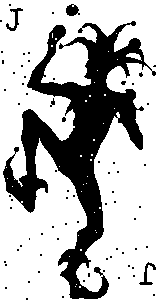
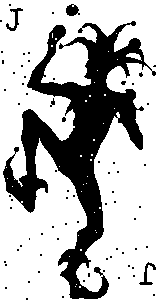
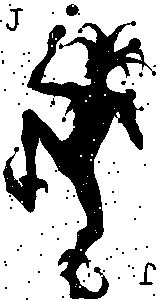
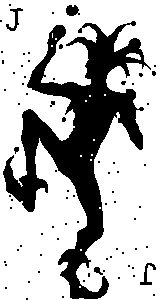
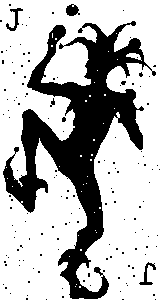
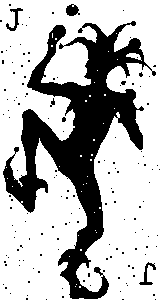
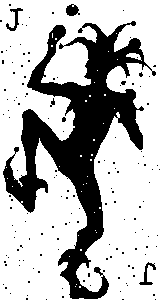
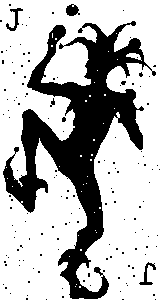
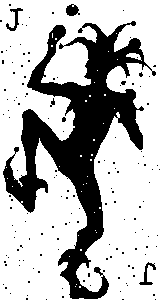
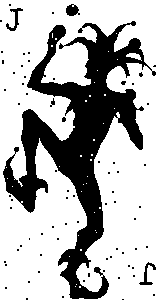
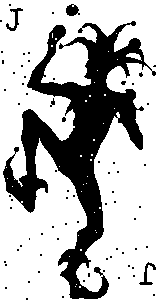
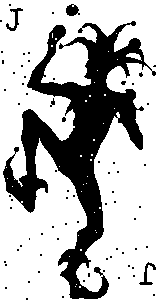
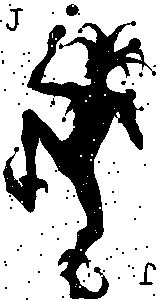
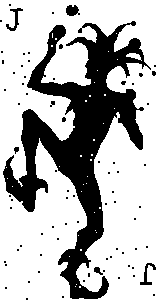
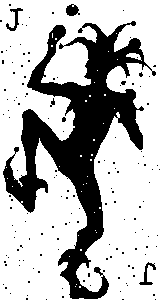
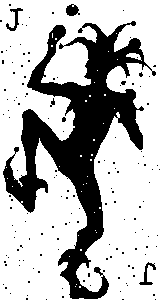
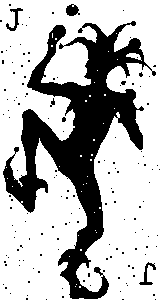
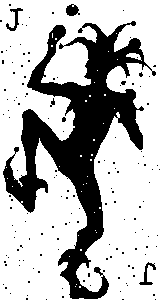
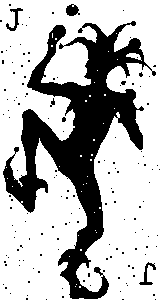
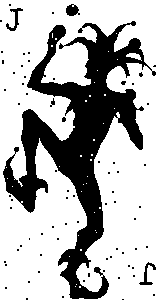
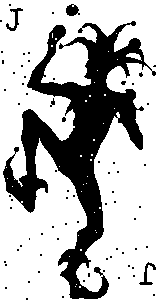
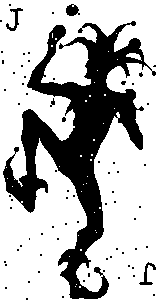
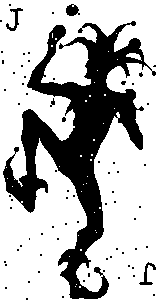
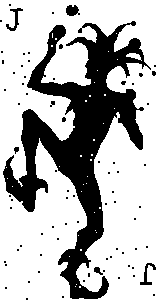
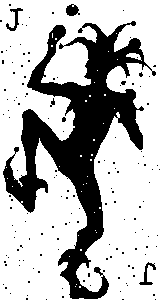
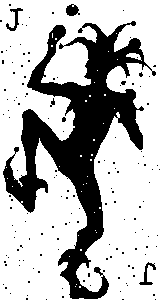
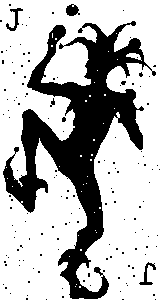
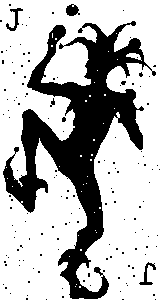
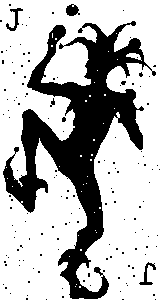
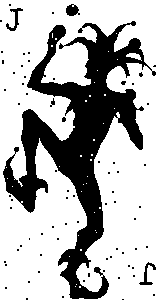
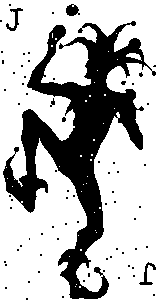
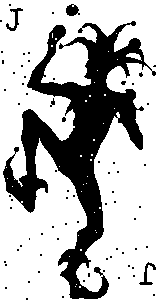
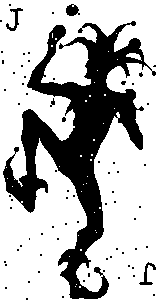
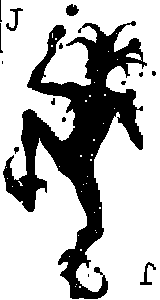

In [28]:

outputs = []
titles = []
rho = 0.7
p_s_range = np.arange(0.0, 1.0, 0.1)
p_diff_range = np.arange(0.0, 1.0, 0.1)

for p_same in p_s_range:
    for p_diff in tqdm(p_diff_range, total=(len(p_diff_range))):
        # if p_diff - 2*p_same <= 0:
        #     continue
        result = denoise_binary_image(image, 
                              rho=rho,
                              c_same=p_same,
                              c_diff=p_diff
                             )
        outputs.append(result['Denoised_I'])
        titles.append(f"P_S={p_same:.2f}/P_D={p_diff:.2f}")
print(len(outputs))
mpy.show_images(outputs, titles=titles, columns=10, downsample=False, width=256, height=100)

If pairwise cost of being the sams is zeor then as the pairwise costs difference increase the image gets more and more smooth until eventually it becomes uniform.

Increasing pairwise of both same and different will cancel them out and the unary costs dominate and you see no change in the output.

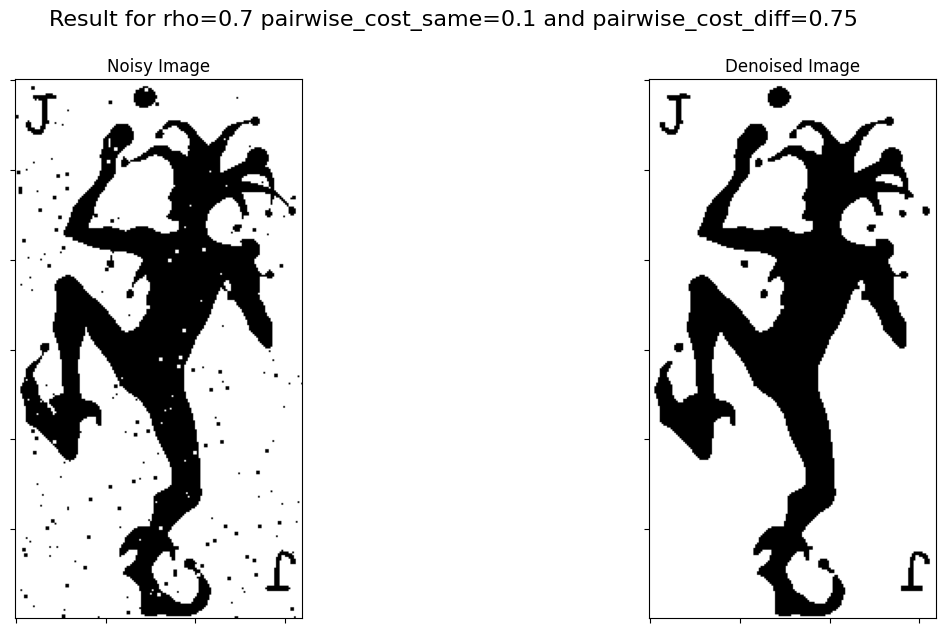

In [13]:
rho = 0.7
pairwise_cost_same = 0.1
pairwise_cost_diff = 0.75

result = denoise_binary_image(image, 
                              rho=rho,
                              c_same=pairwise_cost_same,
                              c_diff=pairwise_cost_diff
                             )
plot_result(image, 
            result['Denoised_I'],
            rho=rho, 
            pairwise_same=pairwise_cost_same, 
            pairwise_diff=pairwise_cost_diff)